In [1]:
!uv pip install langgraph

Using Python 3.11.10 environment at: /home/ubu/Documents/work/l4t/langchain-langgraph-python/.venv
Audited 1 package in 2ms


In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing import Literal

In [ ]:
# Withdrawl Workflow 

class Account(TypedDict):
    accountId: str
    balance: float


class UserInput(TypedDict):
    accountId: str
    amount: float


class TranxStatus(TypedDict):
    failed: bool | None
    code: Literal["NOT_FOUND", "INSUFFICIENT_BALANCE", None]


class State(TypedDict):
    accounts: list[Account]
    userInput: UserInput = None
    tranxStatus: TranxStatus = {"failed": None, "code": None}


graph = StateGraph(State)


def get_accounts_map(accounts: list[Account]) -> object:
    return {account["accountId"]: account for account in accounts}


def get_account(state: State) -> Account | None:
    user_input = state["userInput"]
    account_id = user_input["accountId"]
    accounts_map = get_accounts_map(state["accounts"])
    account = accounts_map.get(account_id, None)
    return account


def get_user_input(state: State) -> State:
    accountId = input("Enter account Id: ")
    amount = float(input("Enter amount to withdraw: "))
    state["userInput"] = {"accountId": accountId, "amount": amount}
    return state


def validate(state: State) -> State:
    account = get_account(state)
    amount = state["userInput"]["amount"]
    if not account:
        state["tranxStatus"] = {"failed": True, "code": "NOT_FOUND"}
    elif account["balance"] < amount:
        state["tranxStatus"] = {"failed": True, "code": "INSUFFICIENT_BALANCE"}
    return state


def condition(state: State) -> Literal["withdraw", "failure"]:
    status = state["tranxStatus"]["failed"]
    if status == True:
        return "failure"
    return "withdraw"


def withdraw(state: State) -> State:
    amount = state["userInput"]["amount"]
    account = get_account(state)
    account["balance"] -= amount
    return state


def print_balance(state: State) -> None:
    account = get_account(state)
    print(f"Balance of Account {account['accountId']} is {account['balance']}")


def failure(state: State) -> None:
    tranxStatus = state["tranxStatus"]
    if tranxStatus["code"] == "NOT_FOUND":
        print("Sorry! Account not found.")
    else:
        print("Sorry! Insufficient balance.")


# add nodes to the graph
graph.add_node("get_user_input", get_user_input)
graph.add_node("validate", validate)
graph.add_node("withdraw", withdraw)
graph.add_node("print_balance", print_balance)
graph.add_node("failure", failure)


# define the edges
graph.add_edge(START, "get_user_input")
graph.add_edge("get_user_input", "validate")

graph.add_conditional_edges("validate", condition)

graph.add_edge("withdraw", "print_balance")
graph.add_edge("print_balance", END)
graph.add_edge("failure", END)


compiled_graph = graph.compile()

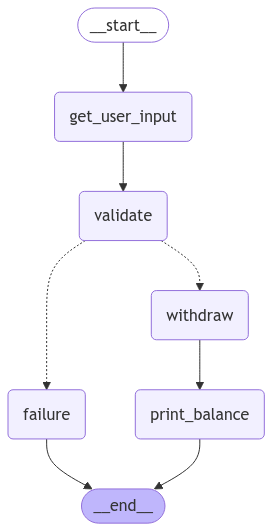

In [ ]:
try:
    display(Image(compiled_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
initial_state = State(
    accounts=[{"accountId": "a1", "balance": 200}, {"accountId": "a2", "balance": 100}],
    userInput=None,
    tranxStatus={"failed": None, "code": None},
)

compiled_graph.invoke(initial_state)


Balance of Account a1 is 180.0


{'accounts': [{'accountId': 'a1', 'balance': 180.0},
  {'accountId': 'a2', 'balance': 100}],
 'userInput': {'accountId': 'a1', 'amount': 20.0},
 'tranxStatus': {'failed': None, 'code': None}}